# Smooth the mask

In this notebook, we apply smoothen algorithm to the mask using spherical harmonic expansion.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations

module_path = '../module/'
sys.path.append(module_path)
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs, LM_list
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize

from Case05_utilities import d2v, d2e, d2f
from Case05_utilities import Uvec2Tvec, Tvec2Uvec
from Case05_utilities import SHVec2mesh, visSHVec, visSH3d
from Case05_utilities import SHvec_rtoc, SHvec_ctor
from Case05_utilities import generate_fcache, generate_Xneigh, generate_Eneigh, generate_Fneigh

In [2]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed'; smoothed = '';
dilated = '_1um_dilated'; dilated = '';
shapename = 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')
dilmaskfile = os.path.join(datadir, shapename+'_Mask_1um_dilated.csv')
newmaskfile = os.path.join(datadir, shapename+'_Mask_smoothed.csv')

# Material properties
mu0 = 300/3;
mu = 1.; nu = 0.499;

# Spherical Harmonics Analysis Settings
lJmax = 30; lKmax = 30; lmax_plot = 60;
lmax_work = np.int(0.8*lKmax); lmax_buf = lJmax-lmax_work;

# target function settings
myalpha = 0.025
mybeta = 0.025

# dump files for minimization
savename = shapename+('_lmax%d'%lJmax)+smoothed+dilated
directory = ''#'../runs/Case05_Shape2'
n_runs = ''
AKfile = 'AK_iter_'+savename+'.npy'
fvfile = 'fv_'+savename+'.txt'

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join(module_path, 'lmax%dmodes'%60)
#################################################################################

Umodes = loadmat(os.path.join(coeff_dir,'Umodes.mat'))
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(os.path.join(coeff_dir,'Tmodes.mat'))
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)
Traction free boundary of v, e, f: (8136,) (24402,) (16268,)


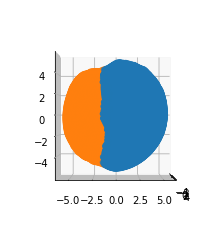

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(np.int)
    mask_dil = np.zeros_like(data[:,0]).astype(np.int)
else:
    mask = np.genfromtxt(maskfile, dtype=np.int)
    mask_dil = np.genfromtxt(dilmaskfile, dtype=np.int)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

Tfv_dil = mask_dil.astype(np.bool)
Tfv = mask.astype(np.bool)
Tfe = np.all(Tfv[Es], axis=1)
Tff = np.all(Tfv[Fs], axis=1)
print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

#### Plot the geometry (Vp) ####
fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
ax.add_collection(eTf)
nTfe = np.logical_not(Tfe)
eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
ax.add_collection(eTf)

ax.view_init(azim=0, elev=0)

ax.set_aspect('equal')
plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [4]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.3097, r0 = 5.2534


We first expand the mask into spherical harmonics. We set the values in between the 1um dilate zone to 1; traction-free boundary to 2, and contact area to 0.

(8136,) (8136, 3)
(8136, 3) (8136,) (8136,)
38.60255950442267


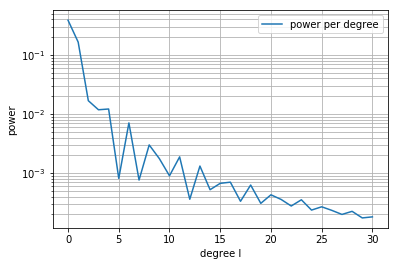

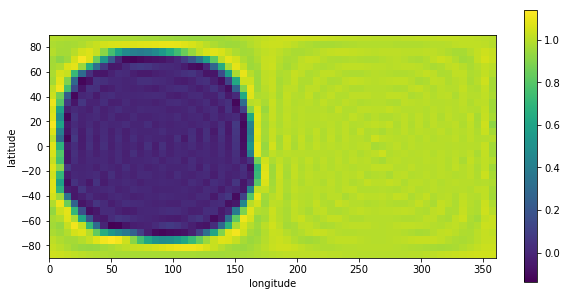

44.35384016055117


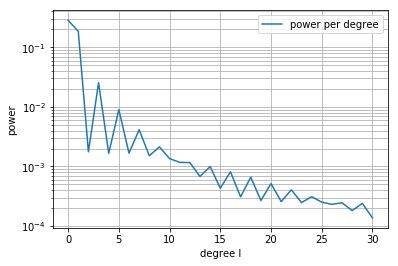

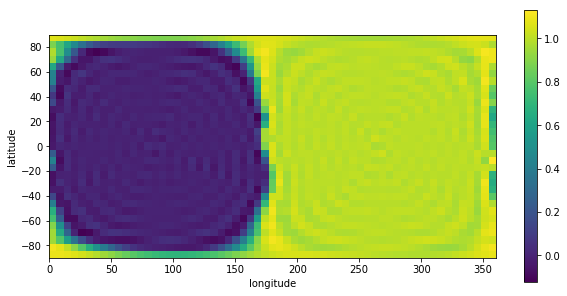

93.41985239216018


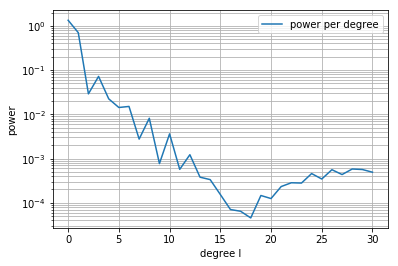

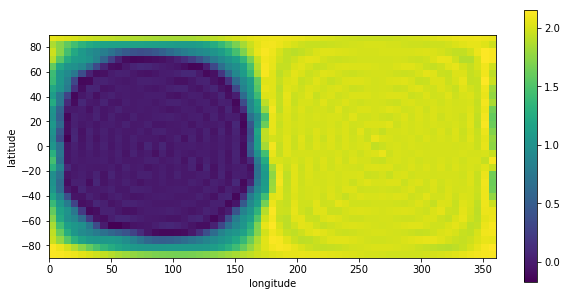

In [5]:
mylmax = lJmax

print(mask.shape, Vp.shape)
Vp_sph = np.stack(CartCoord_to_SphCoord(Vp[..., 0], Vp[..., 1], Vp[..., 2]), axis=-1)
Vlat = 90 - np.rad2deg(Vp_sph[..., 1])
Vlon = np.rad2deg(Vp_sph[..., 2])
print(Vp_sph.shape, Vlat.shape, Vlon.shape)

Tmask_cilm, chi2 = pyshtools.expand.SHExpandLSQ(mask, Vlat, Vlon, lmax=mylmax)
print(chi2)

Tmask_coeff = pyshtools.SHCoeffs.from_array(Tmask_cilm)
fig, ax = Tmask_coeff.plot_spectrum()
Tmask_grid = Tmask_coeff.expand('GLQ')
fig, ax = plotfv(Tmask_grid.to_array(), lonshift=180)

Tmask_cilm, chi2 = pyshtools.expand.SHExpandLSQ(mask_dil, Vlat, Vlon, lmax=mylmax)
print(chi2)

Tmask_coeff = pyshtools.SHCoeffs.from_array(Tmask_cilm)
fig, ax = Tmask_coeff.plot_spectrum()
Tmask_grid = Tmask_coeff.expand('GLQ')
fig, ax = plotfv(Tmask_grid.to_array(), lonshift=180)

Tmask_cilm, chi2 = pyshtools.expand.SHExpandLSQ(mask+mask_dil, Vlat, Vlon, lmax=mylmax)
print(chi2)

Tmask_coeff = pyshtools.SHCoeffs.from_array(Tmask_cilm)
fig, ax = Tmask_coeff.plot_spectrum()
Tmask_grid = Tmask_coeff.expand('GLQ')
fig, ax = plotfv(Tmask_grid.to_array(), lonshift=180)

Then we smooth the mask by damping the coefficients, and evaluate the values onto the original data points.

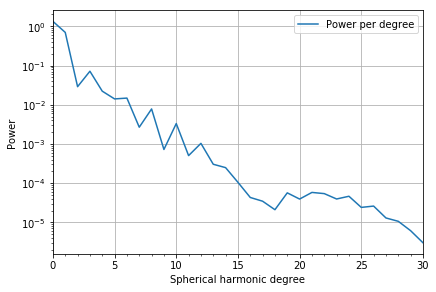

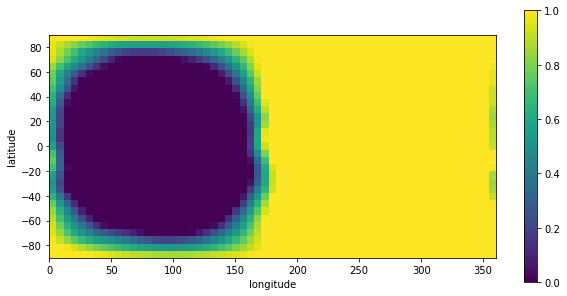

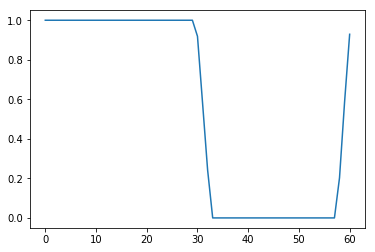

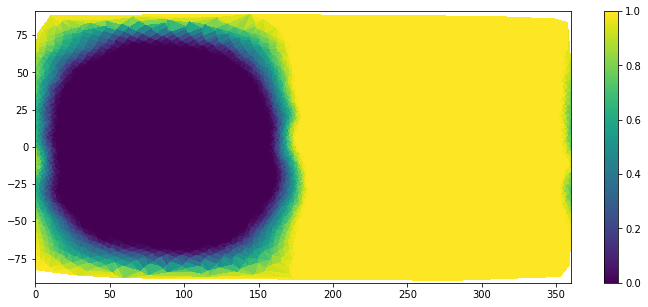

In [6]:
lmax_work = 12; lmax_mean = np.int((mylmax+lmax_work)/2); lmax_buf = mylmax-lmax_work;
lcilm = l_coeffs(lmax=mylmax)
Tmask_damp = sp.special.erfc((lcilm - lmax_mean)/(lmax_buf/2))/2

Tmask_coeff = pyshtools.SHCoeffs.from_array(Tmask_cilm*Tmask_damp)
fig, ax = Tmask_coeff.plot_spectrum()
Tmask_grid = Tmask_coeff.expand('GLQ')
Tmask_grid.data[Tmask_grid.to_array() > 1.9] = 1.9
Tmask_grid.data[Tmask_grid.to_array() < 0.1] = 0.1
Tmask_grid.data = (Tmask_grid.data - 0.1)/1.8
fig, ax = plotfv(Tmask_grid.to_array(), lonshift=180)
plt.plot(Tmask_grid.to_array()[np.int(lJmax/2), :])

Tmask = Tmask_coeff.expand(lat=Vlat, lon=Vlon)
Tmask[Tmask > 1.9] = 1.9
Tmask[Tmask < 0.1] = 0.1
Tmask = (Tmask-0.1) / 1.8

pVlon = Vlon - 180
pVlon[pVlon < 0] += 360
plt.figure(figsize=(12,5))
plt.tripcolor(pVlon, Vlat, Tmask)
plt.colorbar()
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.show()

Save the smoothed traction map (between $[0,1]$)

In [7]:
np.savetxt(newmaskfile, Tmask)